In [21]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import os
import glob
import pandas as pd
import random
import numpy as np
import imageio
from tqdm import tqdm
from PIL import Image
from sklearn.model_selection import train_test_split
from scipy.stats import norm

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend
from keras import layers, Input, Model, ops
from tensorflow.keras.utils import register_keras_serializable

import seaborn as sns
import pickle

# Loading the data

We take the pickle file (`.pkl`) containing the images (in this workbook, from the A1 tile) and the `csv` file containing the redshifts.

In [52]:
# if you make pickle files from the data generator
DATA_PATH = "pickles/A1_compiled_cutouts_3arcsec_30mas.pkl"

# if you download directly from the drive
# DATA_PATH = "A1_compiled_cutouts_3arcsec_30mas.pkl"

In [53]:
# Load data
# rows: ID, image info
with open(DATA_PATH, "rb") as f:
    data = pickle.load(f) 

In [54]:
# IDs
ids = data[0]

# images
images = np.stack(data[1]).astype("float32")
images = np.log10(images - np.min(images)+0.007) # log transform to reduce differences in scale
images = images / np.max(images)  # normalize

Match and merge the datasets based on the object's ID.

In [55]:
attrs = pd.read_csv("cosmos_cut.csv", sep=",")

df_images = pd.DataFrame({'id': ids}) # from ID numbers
df_merged = pd.merge(df_images, attrs, on="id", how="inner") # only when IDs match

images = images[df_merged.index]
redshifts = df_merged["z"].to_numpy(dtype="float32")
redshifts = redshifts / np.max(redshifts) # normalize

Augment data to extend AGN and LRD parts of the database so that the dataset is more balanced:

In [56]:
classes = df_merged["classification"].to_numpy()
obj_ids = df_merged["id"].to_numpy()

aug_images = []
aug_ids = []
aug_redshifts = []

for img, obj_id, z, cls in zip(images, obj_ids, redshifts, classes):
    if cls == "Galaxy":
        # keep as-is, no augmentation
        aug_images.append(img)
        aug_ids.append(obj_id)
        aug_redshifts.append(z)

    elif cls == "AGN":
        # rotations -> 4 total (0°, 90°, 180°, 270°)
        variants = [
            img,
            np.rot90(img, 1, axes=(0, 1)),
            np.rot90(img, 2, axes=(0, 1)),
            np.rot90(img, 3, axes=(0, 1)),
        ]
        for v in variants:
            aug_images.append(v)
            aug_ids.append(obj_id)
            aug_redshifts.append(z)

    elif cls == "LRD":
        # rotations + flips (more aggressive augmentation)
        base_rots = [
            img,
            np.rot90(img, 1, axes=(0, 1)),
            np.rot90(img, 2, axes=(0, 1)),
            np.rot90(img, 3, axes=(0, 1)),
        ]
        variants = base_rots + [
            np.fliplr(img),
            np.flipud(img),
            np.fliplr(base_rots[1]),  # flipped 90°
            np.flipud(base_rots[1]),  # flipped 90°
        ]
        for v in variants:
            aug_images.append(v)
            aug_ids.append(obj_id)
            aug_redshifts.append(z)

    else:
        # any other class: just keep original
        aug_images.append(img)
        aug_ids.append(obj_id)
        aug_redshifts.append(z)

# -------------------------
# final augmented datasets
# -------------------------
aug_images = np.stack(aug_images).astype("float32")
aug_ids = np.array(aug_ids)
aug_redshifts = np.array(aug_redshifts, dtype="float32")

print("Original size:", len(images))
print("Augmented size:", len(aug_images))

Original size: 4512
Augmented size: 4820


In [57]:
# expand metadata to include augmented samples
# takes all instances of an ID
df_aug = pd.DataFrame({"id": aug_ids})
df_aug = df_aug.merge(df_merged, on="id", how="left")

In [ ]:
#Prototype Code

# import os
# import glob
# import pickle
# import numpy as np
# import pandas as pd

# PICKLES_DIR = "pickles"   # folder containing all your .pkl files
# GAL_KEEP_PROB = 1.0 / 8.0 # keep only ~1/8 of galaxies (tune if needed)
# RANDOM_SEED = 24          # for reproducibility (optional)
# LOG_SHIFT = 0.01         # same shift you were using before

# rng = np.random.default_rng(RANDOM_SEED)

# # Load attrs once
# attrs = pd.read_csv("cosmos_cut.csv", sep=",")

# # Use global max z for consistent normalization across all pickles
# z_max = attrs["z"].to_numpy(dtype="float32").max()

# # -------------------------
# # PASS 0: collect file list
# # -------------------------
# pkl_files = sorted(glob.glob(os.path.join(PICKLES_DIR, "*.pkl")))
# print(f"Found {len(pkl_files)} pickle files in {PICKLES_DIR}")

# # ----------------------------------------
# # PASS 1: compute global raw min and max
# # ----------------------------------------
# global_min_raw = np.inf
# global_max_raw = -np.inf

# for pkl_path in pkl_files:
#     print(f"[PASS 1] Scanning {pkl_path} ...")
#     with open(pkl_path, "rb") as f:
#         data = pickle.load(f)

#     # Assume [ids, images, ...]
#     images_raw = np.stack(data[1]).astype("float32")

#     local_min = float(np.min(images_raw))
#     local_max = float(np.max(images_raw))

#     if local_min < global_min_raw:
#         global_min_raw = local_min
#     if local_max > global_max_raw:
#         global_max_raw = local_max

#     # free memory from this file
#     del data, images_raw

# print(f"Global raw min: {global_min_raw}")
# print(f"Global raw max: {global_max_raw}")

# # These define the global log-normalization
# global_max_log = np.log10(global_max_raw - global_min_raw + LOG_SHIFT)
# print(f"Global max (log domain): {global_max_log}")

# # ----------------------------------------
# # PASS 2: preprocess + augment + galaxy cut
# # ----------------------------------------
# aug_images = []
# aug_ids = []
# aug_redshifts = []

# for pkl_path in pkl_files:
#     print(f"[PASS 2] Processing {pkl_path} ...")

#     # -----------------------
#     # Load this pickle
#     # -----------------------
#     with open(pkl_path, "rb") as f:
#         data = pickle.load(f)

#     # Each pickle is assumed to be like [ids, images, ...]
#     ids = np.array(data[0])
#     images_raw = data[1]  # list/array of images

#     # -----------------------
#     # Image preprocessing
#     # -----------------------
#     images = np.stack(images_raw).astype("float32")

#     # global log transform and normalization
#     images = np.log10(images - global_min_raw + LOG_SHIFT)
#     images = images / global_max_log   # consistent across ALL files

#     # -----------------------
#     # Match to attrs
#     # -----------------------
#     df_images = pd.DataFrame({"id": ids})
#     df_merged = pd.merge(df_images, attrs, on="id", how="inner")

#     # Align arrays with merged rows
#     images_sel = images[df_merged.index]
#     redshifts = df_merged["z"].to_numpy(dtype="float32")
#     redshifts = redshifts / z_max  # global z normalization

#     classes = df_merged["classification"].to_numpy()
#     obj_ids = df_merged["id"].to_numpy()

#     # -----------------------
#     # Augmentation + Galaxy cut
#     # -----------------------
#     for img, obj_id, z, cls in zip(images_sel, obj_ids, redshifts, classes):

#         if cls == "Galaxy":
#             # Randomly keep only a fraction of galaxies
#             if rng.random() < GAL_KEEP_PROB:
#                 aug_images.append(img)
#                 aug_ids.append(obj_id)
#                 aug_redshifts.append(z)
#             # else: dropped immediately, never stored

#         elif cls == "AGN":
#             # rotations -> 4 total (0°, 90°, 180°, 270°)
#             variants = [
#                 img,
#                 np.rot90(img, 1, axes=(0, 1)),
#                 np.rot90(img, 2, axes=(0, 1)),
#                 np.rot90(img, 3, axes=(0, 1)),
#             ]
#             for v in variants:
#                 aug_images.append(v)
#                 aug_ids.append(obj_id)
#                 aug_redshifts.append(z)

#         elif cls == "LRD":
#             # rotations + flips (8 variants)
#             base_rots = [
#                 img,
#                 np.rot90(img, 1, axes=(0, 1)),
#                 np.rot90(img, 2, axes=(0, 1)),
#                 np.rot90(img, 3, axes=(0, 1)),
#             ]
#             variants = base_rots + [
#                 np.fliplr(img),
#                 np.flipud(img),
#                 np.fliplr(base_rots[1]),  # flipped 90°
#                 np.flipud(base_rots[1]),  # flipped 90°
#             ]
#             for v in variants:
#                 aug_images.append(v)
#                 aug_ids.append(obj_id)
#                 aug_redshifts.append(z)

#         else:
#             # any other class: just keep original
#             aug_images.append(img)
#             aug_ids.append(obj_id)
#             aug_redshifts.append(z)

#     # Explicitly drop big arrays from this file before moving on
#     del data, ids, images_raw, images, images_sel, redshifts, classes, obj_ids, df_images, df_merged

# # -------------------------
# # final augmented datasets
# # -------------------------
# aug_images = np.stack(aug_images).astype("float32")
# aug_ids = np.array(aug_ids)
# aug_redshifts = np.array(aug_redshifts, dtype="float32")

# print("Final augmented size:", len(aug_images))

# # expand metadata to include augmented samples
# df_aug = pd.DataFrame({"id": aug_ids})
# df_aug = df_aug.merge(attrs, on="id", how="left")


Found 7 pickle files in pickles
[PASS 1] Scanning pickles/A1_compiled_cutouts_3arcsec_30mas.pkl ...
[PASS 1] Scanning pickles/A2_compiled_cutouts_3arcsec_30mas.pkl ...
[PASS 1] Scanning pickles/A3_compiled_cutouts_3arcsec_30mas.pkl ...
[PASS 1] Scanning pickles/A4_compiled_cutouts_3arcsec_30mas.pkl ...
[PASS 1] Scanning pickles/A5_compiled_cutouts_3arcsec_30mas.pkl ...
[PASS 1] Scanning pickles/A6_compiled_cutouts_3arcsec_30mas.pkl ...
[PASS 1] Scanning pickles/A7_compiled_cutouts_3arcsec_30mas.pkl ...
Global raw min: -224.8682098388672
Global raw max: 1981.5382080078125
Global max (log domain): 3.3436874804097703
[PASS 2] Processing pickles/A1_compiled_cutouts_3arcsec_30mas.pkl ...
[PASS 2] Processing pickles/A2_compiled_cutouts_3arcsec_30mas.pkl ...
[PASS 2] Processing pickles/A3_compiled_cutouts_3arcsec_30mas.pkl ...
[PASS 2] Processing pickles/A4_compiled_cutouts_3arcsec_30mas.pkl ...
[PASS 2] Processing pickles/A5_compiled_cutouts_3arcsec_30mas.pkl ...
[PASS 2] Processing pickles/

## Constructing the autoencoder

Since each image is of dimension $(100, 100, 4)$, at the raw scale, they are respresented by $100 \cdot 100 \cdot 4 = 40,000$ values. We choose the number of dimensions to reduce the size of the vector that encodes each input in the latent space. 

In [58]:
LATENT_DIM = 100

The encoder part of the VAE architecture maps a data point to a variational mean and (log) variance. The mean is a point in the latent space.
The "reparameterization trick" draws samples from the variational distribution that are parameterized by the variational mean ($\mu$) and variance ($\sigma^2$), with error $\epsilon$, so that the parameters of the encoder network can be trained.

In [59]:
# ---- Sampling layer that ALSO adds KL via add_loss
@register_keras_serializable(package="Custom") # decorator when saving to model
class Sampling(layers.Layer):
    def __init__(self, beta=1.0, **kwargs):
        """
        Sampling layer for a VAE, applying the reparameterization trick.
        
        Parameters
        ----------
        beta : float
            Weight applied to the KL divergence term (β-VAE).  
            - beta = 1 → standard VAE  
            - beta > 1 → more regularized latent space  
            - beta < 1 → allow more expressive latent
            
        kwargs : passed to layers.Layer
        """
        super().__init__(**kwargs)
        self.beta = beta

    def build(self, input_shape):
        self.rng = keras.random.SeedGenerator(44) # for reproducibility

    def call(self, inputs):
        # unpack encoder outputs
        mean, logvar = inputs

        # ---- (1) Sample ε ~ N(0, I) with same shape as μ
        eps = keras.random.normal(shape=ops.shape(mean),
                                  dtype=mean.dtype,
                                  seed=self.rng)

        # ---- (2) Reparameterization trick
        # Convert log-variance → standard deviation: σ = exp(0.5 * logσ²)
        # Then sample: z = μ + σ * ε
        z = mean + ops.exp(0.5 * logvar) * eps

        # KL per sample
        kl_per_sample = -0.5 * ops.sum(
            1 + logvar - ops.square(mean) - ops.exp(logvar), axis=-1
        )
        # Apply weighting factor (β-VAE trick)
        self.add_loss(self.beta * ops.mean(kl_per_sample))
        return z

In [60]:
# ---- Inputs
img_in = layers.Input(shape=(100, 100, 4), name="image")
z_in   = layers.Input(shape=(1,),          name="redshift")

# ---- Image branch
x = layers.Conv2D(64, 5, padding="same", activation="relu")(img_in)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(64, 3, padding="same", activation="relu")(x)
x = layers.MaxPool2D()(x)
x = layers.Conv2D(32, 3, padding="same", activation="relu")(x)
x = layers.MaxPool2D()(x)
x = layers.Flatten()(x)

# ---- Concatenate image features + redshift
hg = layers.Dense(512, activation="relu")(z_in)
h = layers.Concatenate()([x, hg])
#h = layers.Dense(512, activation="relu")(h)

# ---- Latent parameters
z_mean = layers.Dense(LATENT_DIM, name="z_mean")(h)
z_logv = layers.Dense(LATENT_DIM, name="z_logvar")(h)




# ---- Sampling layer that ALSO adds KL via add_loss
z_latent = Sampling(beta=1.0, name="z")([z_mean, z_logv])

# ---- Encoder model
encoder = Model(inputs=[img_in, z_in],
                outputs=z_latent,
                name="encoder")

encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 100, 100,  │          0 │ -                 │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 100, 100,  │      6,464 │ image[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 50, 50,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 50, 50,    │     36,928 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 25, 25,    │          0 │ conv2d_19[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 25, 25,    │     18,464 │ max_pooling2d_10… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 12, 12,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ redshift            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 4608)      │          0 │ max_pooling2d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 512)       │      1,024 │ redshift[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 5120)      │          0 │ flatten_3[0][0],  │
│ (Concatenate)       │                   │            │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 100)       │    512,100 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_logvar (Dense)    │ (None, 100)       │    512,100 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Sampling)        │ (None, 100)       │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_logvar[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,087,080 (4.15 MB)

 Trainable params: 1,087,080 (4.15 MB)

 Non-trainable params: 0 (0.00 B)

In [61]:
 # ---- Decoder (hybrid upsampling + convolution)

# inputs
d_inputs = Input(shape=(LATENT_DIM,), name='latent_input')

d = layers.Dense(12 * 12 * 64, activation="relu")(z_latent) 
d = layers.Reshape((12, 12, 64))(d)  # start from 12x12

# 12 -> 24
d = layers.UpSampling2D(size=2, interpolation="bilinear")(d)
d = layers.Conv2D(64, 3, padding="same", activation="relu")(d)

# 24 -> 48
d = layers.UpSampling2D(size=2, interpolation="bilinear")(d)
d = layers.Conv2D(64, 3, padding="same", activation="relu")(d)

# 48 -> 96
d = layers.UpSampling2D(size=2, interpolation="bilinear")(d)
d = layers.Conv2D(32, 3, padding="same", activation="relu")(d)

# Final adjustment: 96 -> 100
d = layers.Resizing(100, 100, interpolation="bilinear")(d)

# Output reconstruction (linear activation since it's regression)
x_recon = layers.Conv2D(4, 3, padding="same", activation="linear", name="image_recon")(d)

# ---- Optional small head to reconstruct the scalar redshift as an auxiliary target
z_hat = layers.Dense(32, activation="relu")(z_latent)
z_hat = layers.Dense(1,  activation="linear", name="z_recon")(z_hat)

decoder = Model(z_latent, [x_recon, z_hat])
decoder.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ keras_tensor_83CLO… │ (None, 100)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 9216)      │    930,816 │ keras_tensor_83C… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 12, 12,    │          0 │ dense_10[1][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_9     │ (None, 24, 24,    │          0 │ reshape_3[1][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 24, 24,    │     36,928 │ up_sampling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_10    │ (None, 48, 48,    │          0 │ conv2d_21[1][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (None, 48, 48,    │     36,928 │ up_sampling2d_10… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_11    │ (None, 96, 96,    │          0 │ conv2d_22[1][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (None, 96, 96,    │     18,464 │ up_sampling2d_11… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ resizing_3          │ (None, 100, 100,  │          0 │ conv2d_23[1][0]   │
│ (Resizing)          │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_11 (Dense)    │ (None, 32)        │      3,232 │ keras_tensor_83C… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ image_recon         │ (None, 100, 100,  │      1,156 │ resizing_3[1][0]  │
│ (Conv2D)            │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_recon (Dense)     │ (None, 1)         │         33 │ dense_11[1][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,027,557 (3.92 MB)

 Trainable params: 1,027,557 (3.92 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
autoencoder = keras.Model(inputs=[img_in, z_in], outputs=[x_recon, z_hat], name="vae")

# Only reconstruction losses go in compile. The KL is already attached via add_loss.
autoencoder.compile(
    optimizer=keras.optimizers.Adam(1e-3),
    loss={"image_recon": "mse", "z_recon": "mse"},
    loss_weights={"image_recon": 1000.0, "z_recon": 1.0},)

The VAE model has two main components to its loss function: the reconstruction loss (how well the decoder rebuilds the input features from the latent embeddings) and the KL-divergence loss (how much the encoder's latent distribution deviates from the target prior, usually a standard Gaussian which forces a smooth and continuous latent space). In our architecture, we included the parameter $\beta$ to finetune this tradeoff. 

In addition, the image reconstruction is weighted considerably higher in the loss function than the redshift reconstruction, as it is easier to minimize loss on one scalar than 100x100 pixels. 

In [63]:
autoencoder.summary() # overall architecture

Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 100, 100,  │          0 │ -                 │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_18 (Conv2D)  │ (None, 100, 100,  │      6,464 │ image[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_9     │ (None, 50, 50,    │          0 │ conv2d_18[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (None, 50, 50,    │     36,928 │ max_pooling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_10    │ (None, 25, 25,    │          0 │ conv2d_19[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (None, 25, 25,    │     18,464 │ max_pooling2d_10… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_11    │ (None, 12, 12,    │          0 │ conv2d_20[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ redshift            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_3 (Flatten) │ (None, 4608)      │          0 │ max_pooling2d_11… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 512)       │      1,024 │ redshift[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_3       │ (None, 5120)      │          0 │ flatten_3[0][0],  │
│ (Concatenate)       │                   │            │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 100)       │    512,100 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_logvar (Dense)    │ (None, 100)       │    512,100 │ concatenate_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Sampling)        │ (None, 100)       │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_logvar[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, 9216)      │    930,816 │ z[0][0]           │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape_3 (Reshape) │ (None, 12, 12,    │          0 │ dense_10[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ up_sampling2d_9     │ (None, 24, 24,    │          0 │ reshape_3[0][0]   │
│ (UpSampling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (None, 24, 24,    │     36,928 │ up_sampling2d_9[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,114,637 (8.07 MB)

 Trainable params: 2,114,637 (8.07 MB)

 Non-trainable params: 0 (0.00 B)

# Train the autoencoder

In [64]:
# create training and validation sets
X_train, X_val, z_train, z_val = train_test_split(aug_images, aug_redshifts, test_size=0.2, random_state=42)

z_train = z_train.reshape(-1, 1)
z_val = z_val.reshape(-1, 1)

In [65]:
history = autoencoder.fit(
    [X_train, z_train],               # inputs: images + redshift
    [X_train, z_train],               # targets: reconstruct both
    epochs=40,                         # INCREASE EPOCH COUNT FOR BETTER TRAINING
    batch_size=64,
    validation_data=([X_val, z_val], [X_val, z_val]))

Epoch 1/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - image_recon_loss: 6.1486e-04 - loss: 1.4352 - z_recon_loss: 0.7536

2025-12-02 02:44:19.093384: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'input_concatenate_fusion_1', 4 bytes spill stores, 4 bytes spill loads

2025-12-02 02:44:21.620133: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_14', 4 bytes spill stores, 4 bytes spill loads



61/61 ━━━━━━━━━━━━━━━━━━━━ 19s 194ms/step - image_recon_loss: 1.8255e-04 - loss: 0.7769 - z_recon_loss: 0.5475 - val_image_recon_loss: 2.7146e-05 - val_loss: 0.3144 - val_z_recon_loss: 0.3057
Epoch 2/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 51ms/step - image_recon_loss: 2.4822e-05 - loss: 0.2383 - z_recon_loss: 0.2121 - val_image_recon_loss: 2.5179e-05 - val_loss: 0.2050 - val_z_recon_loss: 0.1701
Epoch 3/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step - image_recon_loss: 2.3030e-05 - loss: 0.1857 - z_recon_loss: 0.1612 - val_image_recon_loss: 2.4567e-05 - val_loss: 0.1642 - val_z_recon_loss: 0.1442
Epoch 4/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - image_recon_loss: 2.2759e-05 - loss: 0.1537 - z_recon_loss: 0.1299 - val_image_recon_loss: 2.4413e-05 - val_loss: 0.1465 - val_z_recon_loss: 0.1244
Epoch 5/40
61/61 ━━━━━━━━━━━━━━━━━━━━ 3s 50ms/step - image_recon_loss: 2.2198e-05 - loss: 0.1346 - z_recon_loss: 0.1118 - val_image_recon_loss: 2.4212e-05 - val_loss: 0.1249 - val_z_recon_loss: 0.1042
Epoc

In [ ]:
autoencoder.save("test8_autoencoder.keras") # save model

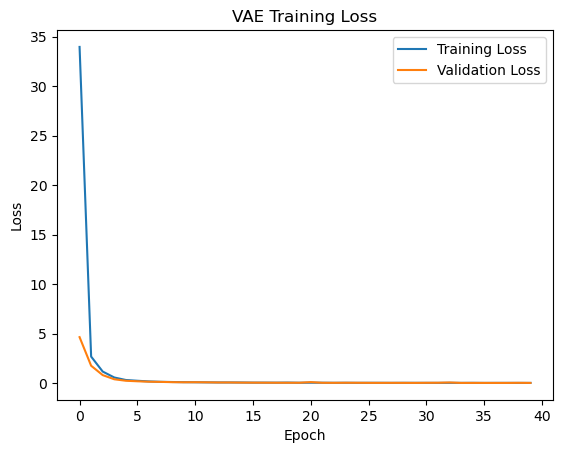

In [15]:
# plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('VAE Training Loss')
plt.legend()
plt.show()

# Visualize samples

In [66]:
def _asinh_stretch(x, scale=None):
    """
    Asinh stretch commonly used for astro images.
    If scale is None, use a robust estimate based on the 90th percentile of |x|.
    """
    x = np.asarray(x)
    if scale is None:
        p = np.nanpercentile(np.abs(x), 90)
        scale = p if p > 0 else np.nanmax(np.abs(x)) + 1e-8
    return np.arcsinh(x / (scale + 1e-12))

def _auto_vmin_vmax(x, pct=(1, 99)):
    """
    Robust display limits from percentiles.

    Parameters
    ----------
    x : array-like
        Image (2D) or any array to compute limits from.
    pct : (low, high)
        Percentiles to use, e.g. (1, 99).

    Returns
    -------
    vmin, vmax : float
        Suggested display limits.
    """
    x = np.asarray(x)
    lo, hi = np.nanpercentile(x, pct)
    if hi <= lo:  # fallback if data are weird/constant
        m, s = np.nanmean(x), np.nanstd(x)
        lo, hi = m - 2 * s, m + 2 * s
    return float(lo), float(hi)

def show_input_vs_output(
    model,
    X,
    z,
    labels,
    idx=0,
    channel_names=None,
    stretch="asinh",      # 'asinh' or 'linear'
    percentiles=(1, 99),  # for linear scaling
    figsize=(12, 6),
    cmap="gray",
    show_residuals=True,
    print_redshift=True):
    """
    Visualize original vs reconstructed image for a single (image, redshift) pair.
    """

    # Prepare the specific sample
    x_true = X[idx]
    z_true = z[idx]
    if z_true.ndim == 0:        # scalar -> (1,)
        z_true = np.array([z_true], dtype=np.float32)
    if z_true.ndim == 1:        # (1,) -> (1,1) when batching
        z_true_b = z_true.reshape(1, 1)
    else:
        z_true_b = z_true.reshape(1, *z_true.shape)

    x_true_b = x_true[np.newaxis, ...]  # (1,H,W,C)

    # Forward pass
    pred = model.predict([x_true_b, z_true_b], verbose=0)
    if isinstance(pred, (list, tuple)):
        x_recon_b = pred[0]
        z_pred_b = pred[1] if len(pred) > 1 else None
    else:
        x_recon_b = pred
        z_pred_b = None

    x_recon = np.squeeze(x_recon_b, axis=0)  # (H,W,C)
    residual = x_recon - x_true

    # --- Redshift scalars (for printing and plotting) ----------------------
    try:
        zt_scalar = float(z_true.ravel()[0])
    except Exception:
        zt_scalar = np.nan

    if z_pred_b is not None:
        zp_scalar = float(np.squeeze(z_pred_b))
    else:
        zp_scalar = None
    # ----------------------------------------------------------------------

    # Print redshifts if desired
    if print_redshift:
        if zp_scalar is not None:
            print(f"z_true = {zt_scalar:.5f} | z_pred = {zp_scalar:.5f}")
        else:
            print(f"z_true = {zt_scalar:.5f} | (model has no z_pred head)")

    H, W, C = x_true.shape
    cols = C
    rows = 3 if show_residuals else 2

    fig, axes = plt.subplots(rows, cols, figsize=figsize, constrained_layout=True)
    if rows == 1:
        axes = np.expand_dims(axes, 0)
    if cols == 1:
        axes = np.expand_dims(axes, 1)

    # <<< NEW: put z_true / z_pred at top of the figure
    if zp_scalar is not None:
        suptitle_str = f" Object type is {labels[idx]} | z_true = {zt_scalar:.5f} | z_pred = {zp_scalar:.5f}"
    else:
        suptitle_str = f"z_true = {zt_scalar:.5f} | (no z_pred)"
    fig.suptitle(suptitle_str, fontsize=14)
    # >>>

    def format_title(base, c):
        if channel_names and c < len(channel_names):
            return f"{base} – {channel_names[c]}"
        return f"{base} – ch{c}"

    for c in range(C):
        # Choose scaling for each panel
        if stretch == "asinh":
            a_true = _asinh_stretch(x_true[..., c])
            a_reco = _asinh_stretch(x_recon[..., c])
            vmin_t, vmax_t = _auto_vmin_vmax(a_true)
            vmin_r, vmax_r = _auto_vmin_vmax(a_reco)
            # Keep separate vmin/vmax for truth vs recon to show structure clearly
            axes[0, c].imshow(a_true, cmap=cmap, vmin=vmin_t, vmax=vmax_t)
            axes[1, c].imshow(a_reco, cmap=cmap, vmin=vmin_r, vmax=vmax_r)
        else:  # linear
            vmin, vmax = _auto_vmin_vmax(x_true[..., c], percentiles)
            axes[0, c].imshow(x_true[..., c], cmap=cmap, vmin=vmin, vmax=vmax)
            axes[1, c].imshow(x_recon[..., c], cmap=cmap, vmin=vmin, vmax=vmax)

        axes[0, c].set_title(format_title("Input", c))
        axes[1, c].set_title(format_title("Reconstruction", c))
        axes[0, c].axis("off")
        axes[1, c].axis("off")

        if show_residuals:
            # Residuals in linear scale centered at 0 with symmetric range
            res = residual[..., c]
            m = np.nanmax(np.abs(res)) + 1e-12
            axes[2, c].imshow(res, cmap=cmap, vmin=-m, vmax=m)
            axes[2, c].set_title(format_title("Residual (recon - input)", c))
            axes[2, c].axis("off")

    plt.show()

    return {
        "x_true": x_true,
        "x_recon": x_recon,
        "z_true": z_true,
        "z_pred": zp_scalar,
        "residual": residual,
    }


z_true = 0.43040 | z_pred = 0.50195


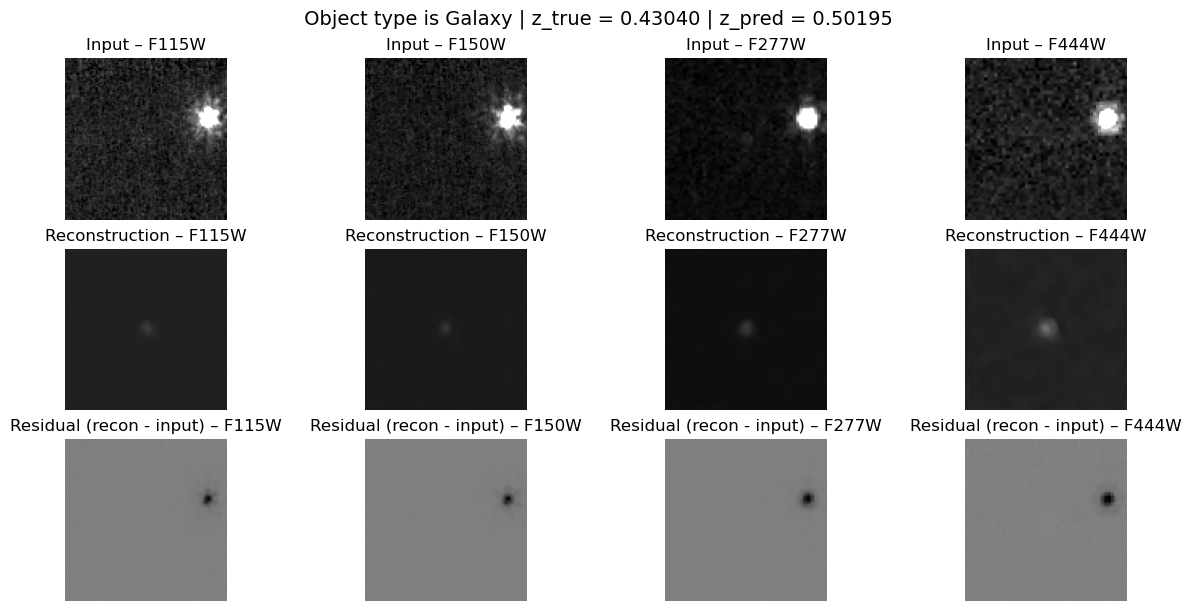

In [67]:
# Example channel labels for 4-band data:
chan_names = ["F115W", "F150W", "F277W", "F444W"]
# Extract classification labels
labels = df_aug["classification"].to_numpy()

# Show sample (change ID as desired)
_ = show_input_vs_output(
    autoencoder,
    aug_images,
    aug_redshifts,
    labels,
    93,
    channel_names=chan_names,
    stretch="linear",      
    show_residuals=True,
    cmap="gray",
)

In [18]:
def _asinh_stretch(x, scale=None):
    """
    Asinh stretch commonly used for astro images.
    If scale is None, use a robust estimate based on the 90th percentile of |x|.
    """
    x = np.asarray(x)
    if scale is None:
        p = np.nanpercentile(np.abs(x), 90)
        scale = p if p > 0 else np.nanmax(np.abs(x)) + 1e-8
    return np.arcsinh(x / (scale + 1e-12))


def _auto_vmin_vmax(x, pct=(1, 99)):
    """
    Robust display limits from percentiles.

    Parameters
    ----------
    x : array-like
        Image (2D) or any array to compute limits from.
    pct : (low, high)
        Percentiles to use, e.g. (1, 99).

    Returns
    -------
    vmin, vmax : float
        Suggested display limits.
    """
    x = np.asarray(x)
    lo, hi = np.nanpercentile(x, pct)
    if hi <= lo:  # fallback if data are weird/constant
        m, s = np.nanmean(x), np.nanstd(x)
        lo, hi = m - 2 * s, m + 2 * s
    return float(lo), float(hi)


def sample_random_latents(decoder, n_samples=8, latent_dim=LATENT_DIM, seed=None):
    """
    Sample random latent vectors from N(0, I) and decode them.

    Parameters
    ----------
    decoder : keras.Model
        Your decoder model: latent -> [image_recon, z_recon].
    n_samples : int
        Number of random samples to generate.
    latent_dim : int
        Dimensionality of the latent space.
    seed : int or None
        Optional RNG seed for reproducibility.

    Returns
    -------
    z_samples : (n_samples, latent_dim) latent vectors
    x_recon   : (n_samples, H, W, C) decoded images
    z_hat     : (n_samples, 1) decoded redshift (if your decoder has that head)
    """
    rng = np.random.default_rng(seed)
    z_samples = rng.normal(size=(n_samples, latent_dim)).astype("float32")

    # decoder outputs [image_recon, z_recon]
    preds = decoder.predict(z_samples, verbose=0)
    if isinstance(preds, (list, tuple)):
        x_recon, z_hat = preds
    else:
        x_recon, z_hat = preds, None

    return z_samples, x_recon, z_hat

def show_random_decoded_samples(
    decoder,
    n_samples=4,
    latent_dim=LATENT_DIM,
    channel_names=None,
    stretch="asinh",      # 'asinh' or 'linear'
    percentiles=(1, 99),
    figsize=(12, 3),
    cmap="gray",
    seed=None,
    print_z_hat=True,
):
    """
    Sample random latents from N(0, I), decode them, and plot the images.

    One row per sample, one column per channel.
    """

    z_samples, x_recon, z_hat = sample_random_latents(
        decoder, n_samples=n_samples, latent_dim=latent_dim, seed=seed
    )

    n, H, W, C = x_recon.shape
    fig, axes = plt.subplots(n, C, figsize=figsize, constrained_layout=True)

    if n == 1:
        axes = np.expand_dims(axes, 0)
    if C == 1:
        axes = np.expand_dims(axes, 1)

    def format_title(base, c):
        if channel_names and c < len(channel_names):
            return f"{base} – {channel_names[c]}"
        return f"{base} – ch{c}"

    for i in range(n):
        for c in range(C):
            img = x_recon[i, ..., c]

            if stretch == "asinh":
                a_img = _asinh_stretch(img)
                vmin, vmax = _auto_vmin_vmax(a_img)
                axes[i, c].imshow(a_img, cmap=cmap, vmin=vmin, vmax=vmax)
            else:  # linear
                vmin, vmax = _auto_vmin_vmax(img, percentiles)
                axes[i, c].imshow(img, cmap=cmap, vmin=vmin, vmax=vmax)

            # Row i = sample i
            if i == 0:
                axes[i, c].set_title(format_title("Sample", c))
            axes[i, c].axis("off")

        if print_z_hat and z_hat is not None:
            try:
                z_val = float(z_hat[i].ravel()[0])
                fig.text(
                    0.01,
                    1.0 - (i + 0.5) / n,
                    f"z_hat ≈ {z_val:.4f}",
                    fontsize=9,
                    va="center",
                )
            except Exception:
                pass

    plt.show()

    return {
        "z_samples": z_samples,
        "x_recon": x_recon,
        "z_hat": z_hat,
    }



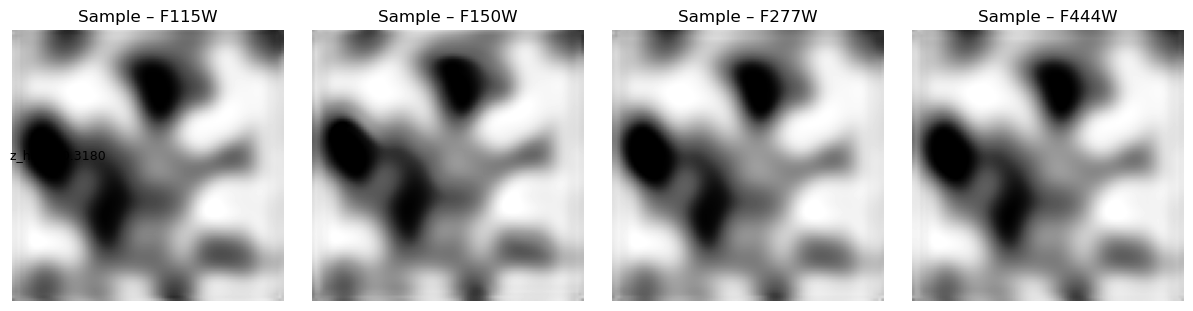

In [30]:
_ = show_random_decoded_samples(
    decoder,
    n_samples=1,
    latent_dim=LATENT_DIM,
    channel_names=["F115W", "F150W", "F277W", "F444W"],
    stretch="linear",
    seed=85,
)


# Visualize the latent space

Since the latent space is set as 100 per the model architecture, we only select the most distinguishing dimensions to construct pairwise plots.

In [108]:
def LatentSpace_pairplot(encoder_model, images, labels, n_dims=4):
    # Encode all images to latent space
    z = encoder_model.predict(images, batch_size=64)
    
    # If latent space > n_dims, only take the first few for clarity
    z = z[:, :n_dims]
    
    # Build a dataframe
    df = pd.DataFrame(z, columns=[f"z{i+1}" for i in range(n_dims)])
    df["classification"] = labels

    # color and transparency maps
    label_to_color = {"LRD": "red", "Galaxy": "dodgerblue", "AGN": "mediumseagreen"}
    label_to_alpha = {"LRD": 1.0, "Galaxy": 0.15, "AGN": 0.45}

    # Plot
    sns.pairplot(df, hue="classification", palette=label_to_color, plot_kws={'alpha':0.4, 's':20})
    plt.suptitle("Latent Space Pairplot by Classification", y=1.02)
    plt.show()

76/76 ━━━━━━━━━━━━━━━━━━━━ -1s -18177us/step


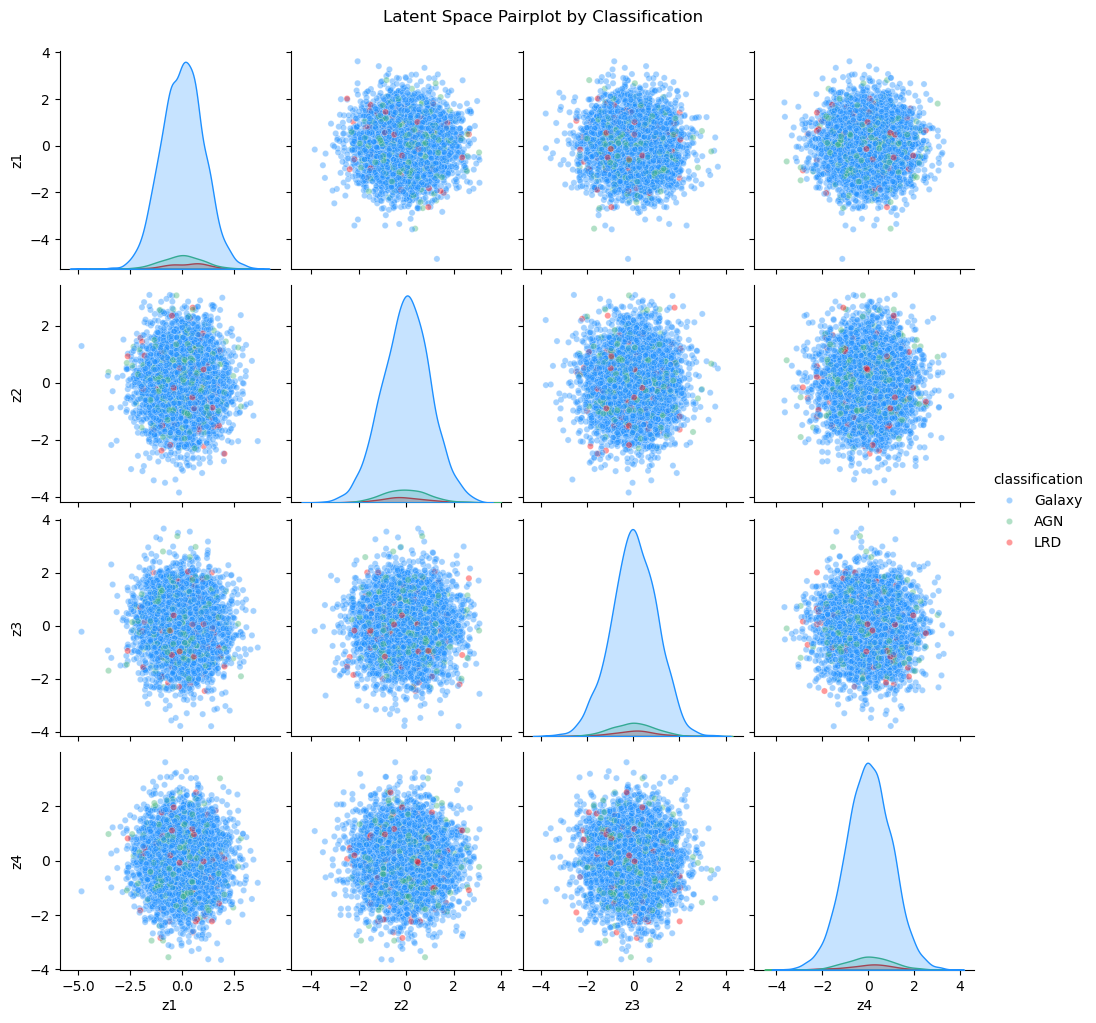

In [109]:
# Extract classification labels
labels = df_aug["classification"].to_numpy()

# Create visualization
LatentSpace_pairplot(encoder, [aug_images, aug_redshifts], labels)

### UMAP

We use Uniform Manifold Approximation and Projection (UMAP) to reduce the dimensionality of the latent space to a 3D projection while preserving both the global structure (overall shape of the data) and local structure (how nearby points relate to each other).

This code loads a saved version of the model. Skip the loading cell if you are still working with the autoencoder

In [36]:
# if you don't have umap
# !pip install umap-learn

There is a known UMAP shadow module in `cuml` which introduces instability and crashes kernels when run on GPU. Run the following block as applicable:

In [ ]:
# detect which UMAP package you're actually using
import umap
print("UMAP path:", umap.__file__)

# If the printed path contains "cuml" or "rapids", then:
# !pip uninstall cuml -y
# !pip install umap-learn

2025-12-01 22:45:42.790489: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-12-01 22:45:42.843098: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-12-01 22:45:44.104746: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


UMAP path: /home/sean/anaconda3/lib/python3.12/site-packages/umap/__init__.py


In [ ]:
#This is the loading cell
autoencoder = keras.models.load_model('test5_autoencoder.keras')

# inputs to the encoder are just the inputs to the autoencoder
img_in_loaded, z_in_loaded = autoencoder.inputs

# latent output is the output of the "z" layer (Sampling)
z_latent_loaded = autoencoder.get_layer("z").output

encoder = keras.Model(
    inputs=[img_in_loaded, z_in_loaded],
    outputs=z_latent_loaded,
    name="encoder_from_ae"
)

encoder.summary()

Model: "encoder_from_ae"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 100, 100,  │          0 │ -                 │
│                     │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 100, 100,  │      6,464 │ image[0][0]       │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (None, 50, 50,    │          0 │ conv2d_6[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 50, 50,    │     36,928 │ max_pooling2d_6[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_7     │ (None, 25, 25,    │          0 │ conv2d_7[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 25, 25,    │     18,464 │ max_pooling2d_7[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_8     │ (None, 12, 12,    │          0 │ conv2d_8[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ redshift            │ (None, 1)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 4608)      │          0 │ max_pooling2d_8[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │      1,024 │ redshift[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_2       │ (None, 5120)      │          0 │ flatten_2[0][0],  │
│ (Concatenate)       │                   │            │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_mean (Dense)      │ (None, 100)       │    512,100 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z_logvar (Dense)    │ (None, 100)       │    512,100 │ concatenate_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ z (Sampling)        │ (None, 100)       │          0 │ z_mean[0][0],     │
│                     │                   │            │ z_logvar[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,087,080 (4.15 MB)

 Trainable params: 1,087,080 (4.15 MB)

 Non-trainable params: 0 (0.00 B)

76/76 ━━━━━━━━━━━━━━━━━━━━ 3s 21ms/step


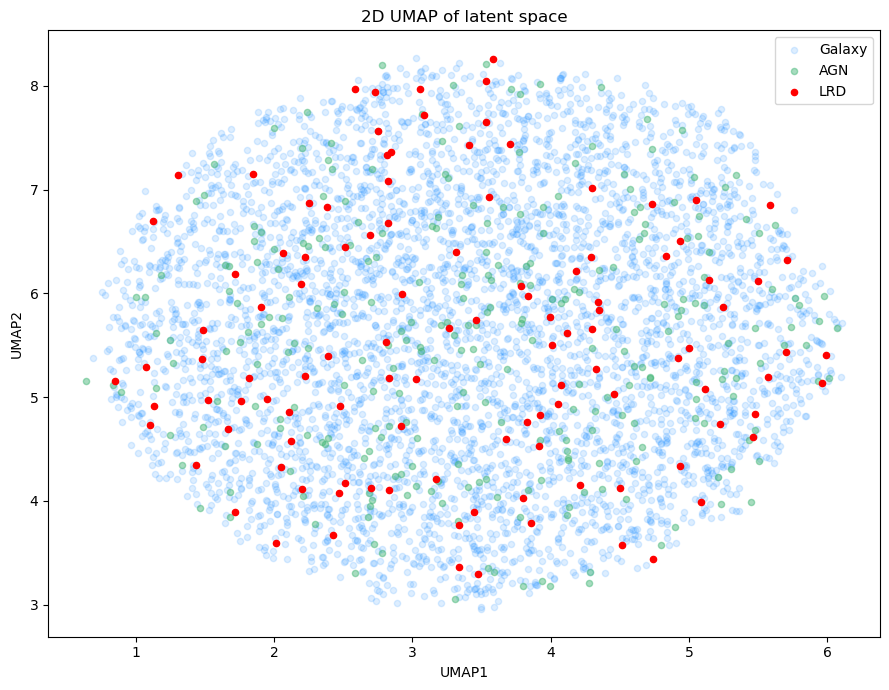

In [ ]:


# ---------- 1) Get latent space from encoder ----------
latent_space = encoder.predict([aug_images, aug_redshifts],
                                batch_size=64)

# ---------- 2) Run 2D UMAP ----------
reducer_2d = umap.UMAP(
    n_neighbors=50,
    min_dist=0.1,
    n_components=2,      # <-- 2D now
    metric='euclidean'
)

latent_umap_2d = reducer_2d.fit_transform(latent_space)

# ---------- 3) Put into DataFrame ----------
df_latent_2d = pd.DataFrame(latent_umap_2d, columns=['UMAP1', 'UMAP2'])
df_latent_2d['classification'] = df_aug['classification'].values

# ---------- 4) Plot 2D scatter ----------
label_to_color = {"LRD": "red", "Galaxy": "dodgerblue", "AGN": "mediumseagreen"}
label_to_alpha = {"LRD": 1.0, "Galaxy": 0.15, "AGN": 0.45}

plt.figure(figsize=(9, 7))

for cls in df_latent_2d['classification'].unique():
    subset = df_latent_2d[df_latent_2d['classification'] == cls]
    plt.scatter(
        subset['UMAP1'],
        subset['UMAP2'],
        color=label_to_color[cls],
        alpha=label_to_alpha[cls],
        label=cls,
        s=20
    )

plt.xlabel('UMAP1')
plt.ylabel('UMAP2')
plt.title('2D UMAP of latent space')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
reducer = umap.UMAP(
    n_neighbors=15,      # local neighborhood size
    min_dist=0.1,        # how tightly UMAP packs points
    n_components=3,      # output dimensions (2D or 3D)
    metric='euclidean')   # distance metric

latent_space = encoder.predict([aug_images, aug_redshifts])

151/151 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


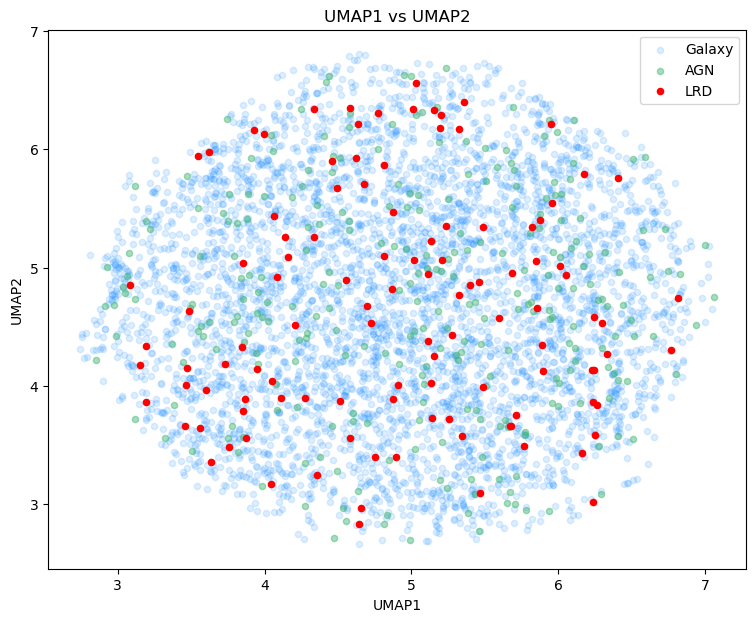

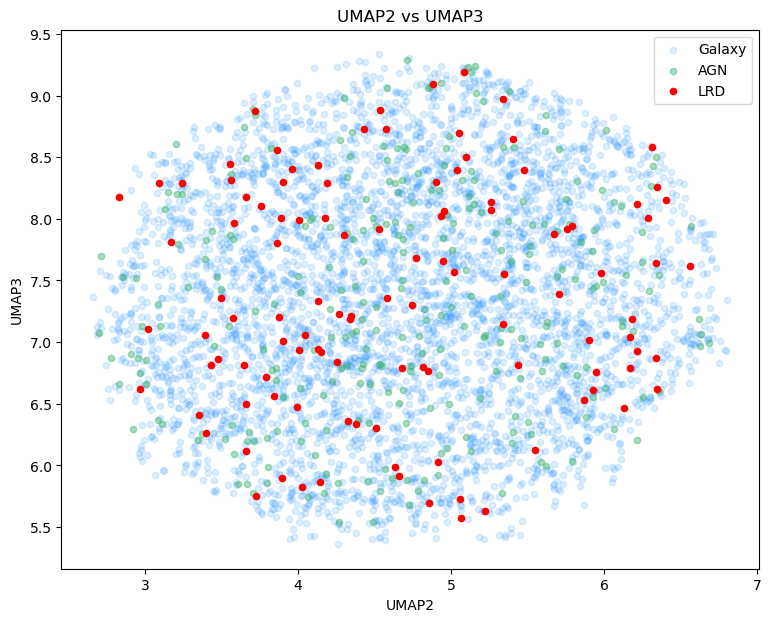

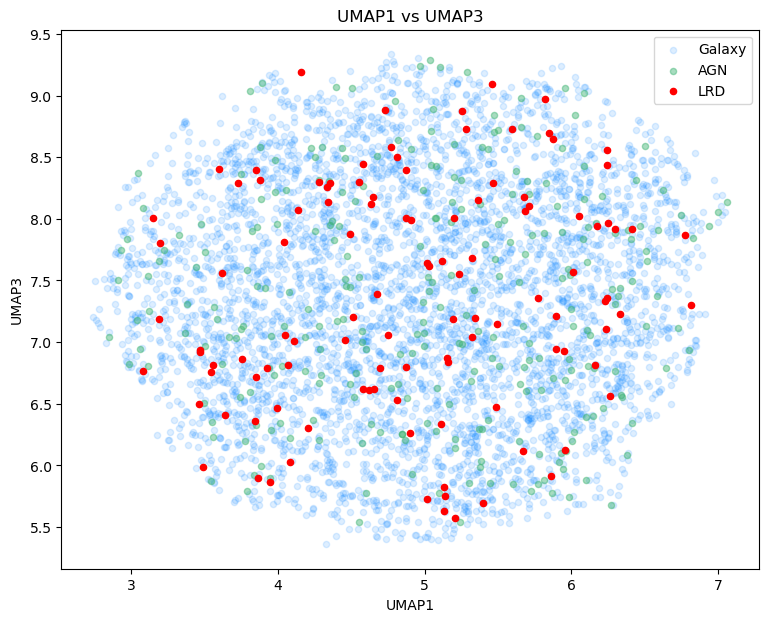

In [19]:
# create reduced dimension latent space
latent_umap = reducer.fit_transform(latent_space)
latent_dims = ['UMAP1', 'UMAP2', 'UMAP3']

df_latent = pd.DataFrame(latent_umap, columns=latent_dims)
df_latent['classification'] = df_aug['classification']

# color + alpha mapping to highlight LRDs
label_to_color = {"LRD": "red", "Galaxy": "dodgerblue", "AGN": "mediumseagreen"}
label_to_alpha = {"LRD": 1.0, "Galaxy": 0.15, "AGN": 0.45}

# pairwise plots 
plot_pairs = [('UMAP1', 'UMAP2'), ('UMAP2', 'UMAP3'), ('UMAP1', 'UMAP3')]

for x_dim, y_dim in plot_pairs:
    plt.figure(figsize=(9, 7))
    
    for cls in df_latent['classification'].unique():
        subset = df_latent[df_latent['classification'] == cls]
        plt.scatter(subset[x_dim], subset[y_dim],
                    color=label_to_color[cls],
                    alpha=label_to_alpha[cls],
                    label=cls,
                    s=20)
    
    plt.xlabel(x_dim)
    plt.ylabel(y_dim)
    plt.legend()
    plt.title(f"{x_dim} vs {y_dim}")
    plt.show()

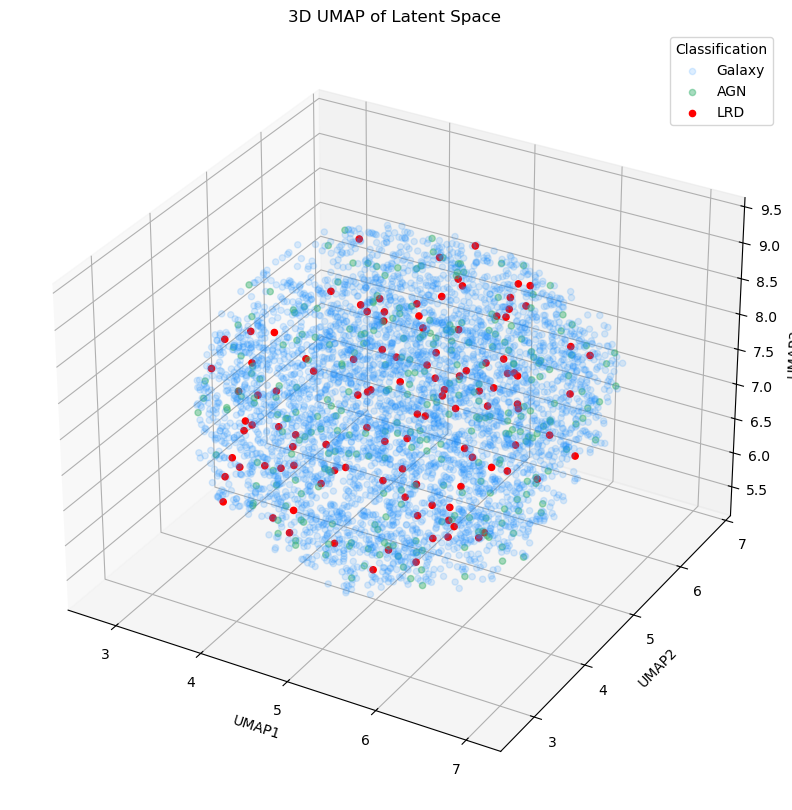

In [20]:
# 3D plot to see latent dimensions at once
from mpl_toolkits.mplot3d import Axes3D

# create figure and 3D axes
fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# plot for each classification to maintain different alpha levels
for cls in df_latent['classification'].unique():
    subset = df_latent[df_latent['classification'] == cls]
    ax.scatter(subset['UMAP1'], subset['UMAP2'], subset['UMAP3'],
                   c=label_to_color[cls],
                   alpha=label_to_alpha[cls],
                   label=cls,
                   s=20)
    
ax.set_xlabel('UMAP1')
ax.set_ylabel('UMAP2')
ax.set_zlabel('UMAP3')
ax.legend(title = 'Classification')
ax.set_title('3D UMAP of Latent Space')

plt.show()

## Compare latent space distances

In [82]:
from scipy.spatial.distance import cdist

# Make data frames for separate classes
latent_LRD = df_latent[df_latent['classification'] == 'LRD'][['UMAP1','UMAP2','UMAP3']].values
latent_Galaxy = df_latent[df_latent['classification'] == 'Galaxy'][['UMAP1','UMAP2','UMAP3']].values
latent_AGN = df_latent[df_latent['classification'] == 'AGN'][['UMAP1','UMAP2','UMAP3']].values

# Euclidean distances from each LRD to every point in the other groups
dist_LRD_Galaxy = cdist(latent_LRD, latent_Galaxy)
dist_LRD_AGN = cdist(latent_LRD, latent_AGN)

# For each LRD, keep the nearest distance to each group
df_LRD = df_latent[df_latent['classification'] == 'LRD'].copy()
df_LRD['nearest_galaxy'] = dist_LRD_Galaxy.min(axis=1)
df_LRD['nearest_agn'] = dist_LRD_AGN.min(axis=1)

# Summary statistics
summary_panel = df_LRD[['nearest_galaxy', 'nearest_agn']].describe(percentiles=[.25, .5, .75]).T
summary_panel.rename(columns={
    '25%': 'Q1',
    '50%': 'Median',
    '75%': 'Q3'}, inplace=True)
summary_panel = summary_panel[['min','Q1','Median','Q3','max','mean','std']]

print(summary_panel)

                    min        Q1    Median        Q3       max      mean  \
nearest_galaxy  0.01151  0.072590  0.101151  0.127549  0.186775  0.100155   
nearest_agn     0.06181  0.186907  0.254012  0.321302  0.594400  0.264027   

                     std  
nearest_galaxy  0.040000  
nearest_agn     0.105336  


*insert conclusions here once I have a model that can be trained for more than 1 epoch*